<a href="https://colab.research.google.com/github/shawk17/563-shawk17/blob/main/Hoomd_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2
## Hoomd

### Install

3 Ways to install, use Conda (uses pip), pip

In [ ]:
# Install
!pip install -q condacolab
# Creates a repository
!git clone --single-branch --branch cecam https://github.com/cmelab/hoomd-organics
# This will crash the session, restart collab and changes seesion
import condacolab
condacolab.install()

Cloning into 'hoomd-organics'...
remote: Enumerating objects: 3573, done.
remote: Counting objects: 100% (890/890), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 3573 (delta 735), reused 706 (delta 706), pack-reused 2683 (from 1)
Receiving objects: 100% (3573/3573), 1.53 MiB | 8.84 MiB/s, done.
Resolving deltas: 100% (2462/2462), done.
⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [ ]:
#!pip install --upgrade ipykernel #breaks things?
import os
os.chdir("hoomd-organics")
# For packaging .yml to organize depencies
!mamba env update -n base -f environment-cpu.yml
!python -m pip install -e .
import warnings
warnings.filterwarnings('ignore')

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



cudatoolkit-11.8.0   | 682.5 MB  | :   0% 0/1 [00:00<?, ?it/s]
gcc_impl_linux-64-14 | 70.1 MB   | :   0% 0/1 [00:00<?, ?it/s]

pillow-11.1.0        | 40.1 MB   | :   0% 0/1 [00:00<?, ?it/s]


libllvm14-14.0.6     | 30.0 MB   | :   0% 0/1 [00:00<?, ?it/s]



libflint-3.1.3.1     | 20.2 MB   | :   0% 0/1 [00:00<?, ?it/s]




rdkit-2024.09.6      | 19.0 MB   | :   0% 0/1 [00:00<?, ?it/s]





parmed-4.3.0         | 18.5 MB   | :   0% 0/1 [00:00<?, ?it/s]






scipy-1.15.2         | 16.4 MB   | :   0% 0/1 [00:00<?, ?it/s]







libclang-cpp14-14.0. | 15.8 MB   | :   0% 0/1 [00:00<?, ?it/s]








pandas-2.2.3         | 15.0 MB   | :   0% 0/1 [00:00<?, ?it/s]









sysroot_linux-64-2.1 | 14.5

## Using Hoomd
* Initialize LJ system
* run NVE simulation

### MD Simulation

#### Simulation Setup

##### Imports

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import gsd.hoomd
import hoomd
import freud
import numpy as np
import os

cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=5)

print(sim.state)
print(sim.operations.integrator)
print(sim.operations.updaters[:])
print(sim.operations.writers[:])

None
None
[]
[]


##### Lennard-Jones Class

In [ ]:
class LennardJones:
    def __init__(self, replicas, sigma=1, epsilon=1, kT=1, r_cut=2.5, dt = 0.005, buffer = 0.4,
                 rho=0.5, period = 10000, log_file = 'log.gsd'):
      self.sigma = sigma
      self.epsilon = epsilon
      self.r_cut = r_cut
      self.kT = kT
      self.dt = dt
      self.buffer = buffer
      self.cpu = hoomd.device.CPU()
      self.sim = hoomd.Simulation(device=cpu, seed=5)
      self.rho = rho
      self.replicas = replicas
      self.N = replicas**3
      self.period = period
      self.log_file = log_file

      self.setup_system()
      self.setup_LJ()
      self.setup_logger()


    def setup_LJ(self):
      self.integrator = hoomd.md.Integrator(dt=self.dt)
      self.cell = hoomd.md.nlist.Cell(buffer=self.buffer)
      self.lj = hoomd.md.pair.LJ(nlist=self.cell)
      self.lj.params[('A', 'A')] = dict(epsilon=self.epsilon, sigma=self.sigma)
      self.lj.r_cut[('A', 'A')] = self.r_cut*self.sigma
      self.integrator.forces.append(self.lj)
      self.nvt = hoomd.md.methods.NVE(filter=hoomd.filter.All())
      self.integrator.methods.append(self.nvt)

    def setup_system(self):
      #a is the spacing between particles
      self.a = 1/(self.rho**(1/3.0))
      self.grid_particles = freud.data.UnitCell([self.a,self.a,self.a,0,0,0],[[0,0,0]]).generate_system(self.replicas)
      self.L = self.grid_particles[0].Lx

      self.frame = gsd.hoomd.Frame()
      self.frame.particles.N = self.N
      self.frame.particles.position = self.grid_particles[1]
      self.frame.configuration.box = [self.L,self.L,self.L,0,0,0]
      self.frame.particles.typeid = [0]*self.N
      self.frame.particles.types = ['A']

      #Finally, save our initial state:
      with gsd.hoomd.open(name='initial_state.gsd', mode='wb') as f:
          f.append(self.frame)

    def setup_logger(self):
      self.sim.create_state_from_gsd(filename='initial_state.gsd')
      self.sim.operations.integrator = self.integrator
      self.sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=self.kT)
      self.thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
      self.sim.operations.computes.append(self.thermodynamic_properties)
      self.sim.run(0)

      # Logger setup
      self.logger = hoomd.logging.Logger(categories=['scalar',])
      self.logger.add(self.sim, ['timestep'])
      self.logger.add(self.thermodynamic_properties, ['kinetic_energy', 'potential_energy'])
      self.writer = hoomd.write.GSD(
          trigger=hoomd.trigger.Periodic(self.period),
          filename=self.log_file, logger = self.logger, mode='wb')
      self.sim.operations.writers.append(self.writer)



    def run(self, steps):
      self.sim.run(steps)

    def __del__(self):
      print('Deleted')
      del self.sim


In [ ]:
replicas = 10
dt= [0.0005, 0.001, 0.005, 0.01, 0.05]

for i,t in enumerate(dt):
  print(t)
  lj = LennardJones(replicas, sigma=1, epsilon=1, kT=1, r_cut=2.5, dt = t, buffer = 0.4,
                  rho=1, period = 500, log_file=f'log{i}.gsd')
  try:
    lj.run(100000)
  except:
    print(f"Error on time step {lj.sim.timestep}, ")

  del lj

0.0005


/usr/local/lib/python3.11/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


0.001
Deleted
0.005
Deleted
0.01
Deleted
0.05
Deleted


**ERROR**: Particle with unique tag 456 is no longer in the simulation box.

Cartesian coordinates: 
x: -3.02372e+08 y: -7.41389e+08 z: 2.16366e+08
Fractional coordinates: 
f.x: -3.02372e+07 f.y: -7.41389e+07 f.z: 2.16366e+07
Local box lo: (-5, -5, -5)
          hi: (5, 5, 5)


Error on time step 2, 


Deleted


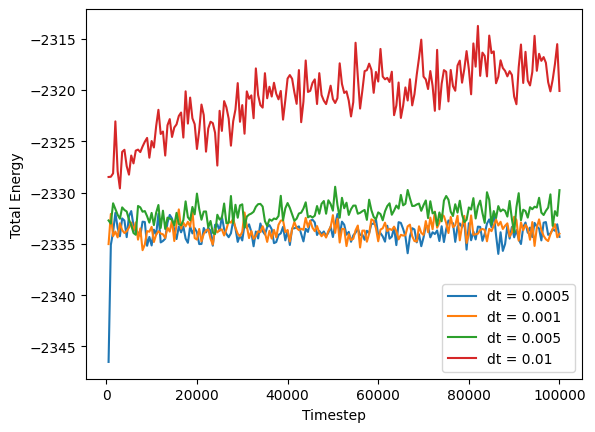

In [ ]:
# Open the GSD file
for i in range(len(dt)-1):
  with gsd.hoomd.open(f'log{i}.gsd', 'r') as log_file:
      timesteps = []
      kinetic_energies = []
      potential_energies = []

      for frame in log_file:
          timesteps.append(frame.log['Simulation/timestep'][0])
          kinetic_energies.append(frame.log['md/compute/ThermodynamicQuantities/kinetic_energy'][0])
          potential_energies.append(frame.log['md/compute/ThermodynamicQuantities/potential_energy'][0])

  # Compute total energy
  total_energies = np.array(kinetic_energies) + np.array(potential_energies)

  # Plot results
  plt.plot(timesteps, total_energies, label=f'dt = {dt[i]}')

plt.xlabel('Timestep')
plt.ylabel('Total Energy')
plt.legend()
plt.show()
# The 0.05 time step was to large and didn't run.

## Math Therory and Limitations
NVE: microcanonical ensemble, entropy is well defined. Easiest to implement in MD, KE ↔ PE.

Shadow Hamilotian: Samples the same space, but in a different order.

### Reading Algorithm
* Read the whole thing, straight thru.
  * Not allowed to stop
  * Possibly read out loud.
* Pick a couple questions
  * Interesting
  * Thing you need to understand
  * Homework
* Re-read trying to answer questions
  * Allowed to skip arround

### Radial Distribution Functions

* A structural measure from configuration
* Deeply connected to theory
  * g(r) → PE
  * g(r) → S(q) Structure factor
  * g(r) → FE (free energy)
* Trajectory: Sequence of configurations
  * 6N dof (3N coordinates, velocities)
  * -3 (NVE, NVT, ect)
  * 1000 particles, 5997 dof
* What is the probabilty two particles are distance r apart?
  * Spherical Anulus
  * Ideal gas probablity
    * $g(r) = \frac 12 N ρ (\frac 43 π) ((r+Δr)^3 - r^3)$
    * $g(r) → 1 lim(r → ∞)$
    * First minimum (depletion well), distguish between first and second hydration cell
    * 2.5 sigma
